# Introduction to Machine Learning
## Project Phase 1

Sina Fathi | 402111261

Seyyed Amirmahdi Sadrzadeh | 401102015

### Part 1: Data Preproccessing

First we import the needed libraries:

In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import binarize

Now we use torch library to load the MNIST dataset and then turn them to numpy arrays:

In [2]:
mnist = fetch_openml('mnist_784', version=1)

X_train = mnist.data / 255.0
Y_train = mnist.target

To use the datas, we binarize them by setting a threshold equal to 128. So all pixels with values higher than 128 will be set to 1 and others will be set to 0. We also flatten the datas to use them in our model:

In [3]:
threshold = 0.5
X_train_binary = binarize(X_train, threshold=threshold)

The plot to show the samples:

In [4]:
# Display a few samples from the binary dataset
def show_samples(samples, nrows=2, ncols=5):
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 5))
    for i, ax in enumerate(axes.flat):
        # Reshape each sample back to (28, 28) for display
        ax.imshow(samples[i].reshape(28, 28), cmap='binary')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

And now we use the above function to show 10 samples from the dataset:

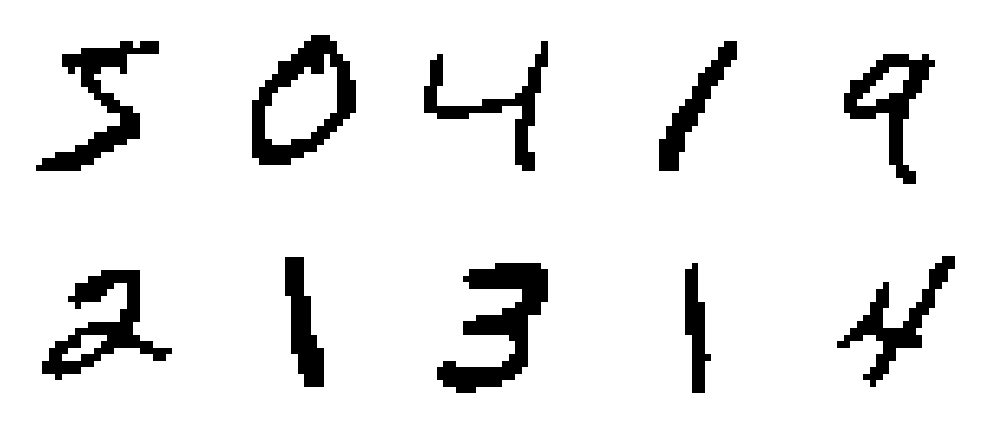

In [5]:
show_samples(X_train_binary[:10])

### Part 2: Implementing the model

To implement the RBM class, we initialize the values of the model parameters by setting the number of layers, the learning rate , and weights and biases. We set the initial values of biases to zero and set the initial values of the weights to a small value using gaussian distribution.

For the contstrative divergence, we use the algorythm in the theory part and implement the method accordingly.

The other part are like the classes we have implemented before.

You can see the RBM class below:

In [6]:
class RBM:
    def __init__(self, n_visible, n_hidden, learning_rate=0.1):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate
        self.W = np.random.normal(0, 0.1, (n_visible, n_hidden))
        self.v_bias = np.zeros(n_visible)
        self.h_bias = np.zeros(n_hidden)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sampleHid(self, vis):
        hid_prob = self.sigmoid(np.dot(vis, self.W) + self.h_bias)
        return hid_prob, np.random.binomial(1, hid_prob)

    def sampleVis(self, hid):
        vis_prob = self.sigmoid(np.dot(hid, self.W.T) + self.v_bias)
        return vis_prob, np.random.binomial(1, vis_prob)

    def contrastive_divergence(self, v, k):
        h_prob, h_sample = self.sampleHid(v)
        positive_grad = np.dot(v.T, h_prob)

        v_neg = v
        for _ in range(k):
            h_prob, h_sample = self.sampleHid(v_neg)
            v_prob_neg, v_neg = self.sampleVis(h_sample)

        negative_grad = np.dot(v_neg.T, h_prob)

        self.W += self.learning_rate * (positive_grad - negative_grad)
        self.v_bias += self.learning_rate * np.sum(v - v_neg, axis=0)
        self.h_bias += self.learning_rate * np.sum(h_prob - h_sample, axis=0)

        return v_neg

    def train(self, data, epochs=10, k=1):
        n_samples = data.shape[0]
        for epoch in range(epochs):
            epoch_loss = 0
            for i in data:
                v_neg = self.contrastive_divergence(i.reshape(1, -1), k)
                epoch_loss += np.mean((i - v_neg) ** 2)
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / n_samples:.4f}")

    def generate_samples(self, n_samples=10, k=1):
        samples = np.random.rand(n_samples, self.n_visible)
        samples = self.gibbs_sampling(samples, k)
        return samples

Now that we have completely implemented the class, we use the code below to train the model.

You can see the loss of each epoch and how the model converges for different values of k (1, 5, 10).

In [ ]:
# Initialize and train RBM for different values of k
n_visible = X_train_binary.shape[1]
n_hidden = 64
k_values = [1, 5, 10]
rbms = {}

for k in k_values:
    print(f"Training RBM with k={k}")
    rbm = RBM(n_visible, n_hidden)
    rbm.train(X_train_binary, epochs=5, k=k)
    rbms[k] = rbm

Training RBM with k=1
Epoch 1/5, Loss: 0.1116
Epoch 2/5, Loss: 0.1131


<ipython-input-6-2a7c44dbab9b>:11: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 3/5, Loss: 0.1150
Epoch 4/5, Loss: 0.1170
Epoch 5/5, Loss: 0.1165
Training RBM with k=5
Epoch 1/5, Loss: 0.0958
Epoch 2/5, Loss: 0.0932
Epoch 3/5, Loss: 0.0940
Epoch 4/5, Loss: 0.0939
Epoch 5/5, Loss: 0.0941
Training RBM with k=10
Epoch 1/5, Loss: 0.0995
Epoch 2/5, Loss: 0.0943


Now to see the generated samples of the model, we use the function below:

In [42]:
def show_generated_samples(rbm, k, n_samples=10):
    print(f"Generated samples for k={k}")
    samples = rbm.generate_samples(n_samples, k)
    samples = samples.reshape((-1, 28, 28))
    fig, axes = plt.subplots(1, n_samples, figsize=(15, 3))
    for i, ax in enumerate(axes):
        ax.imshow(samples[i], cmap='binary')
        ax.axis('off')
    plt.show()

Generated samples for k=1


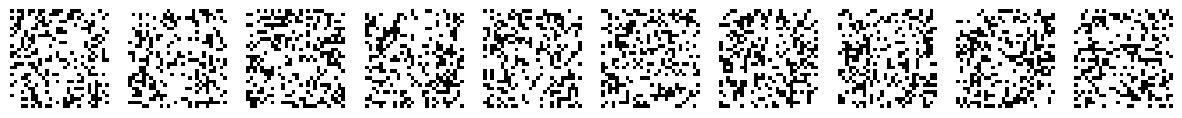

Generated samples for k=5


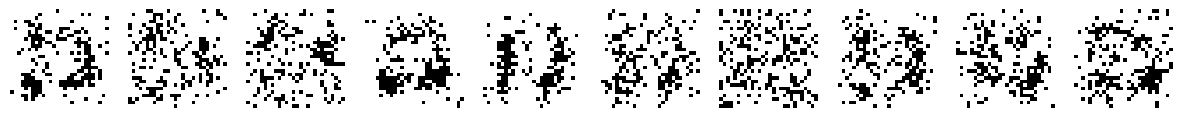

Generated samples for k=10


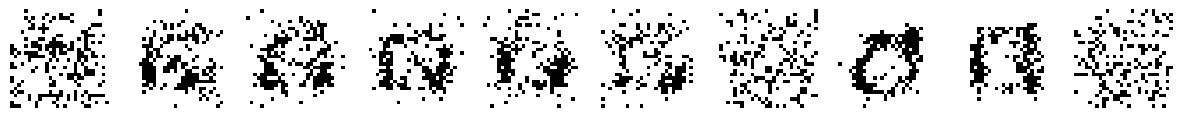

In [43]:
for k in k_values:
    show_generated_samples(rbms[k], k)

We can see that by increasing the value of k, the numbers generated become much more clear.

### Part 3: Showing the sampling proccess


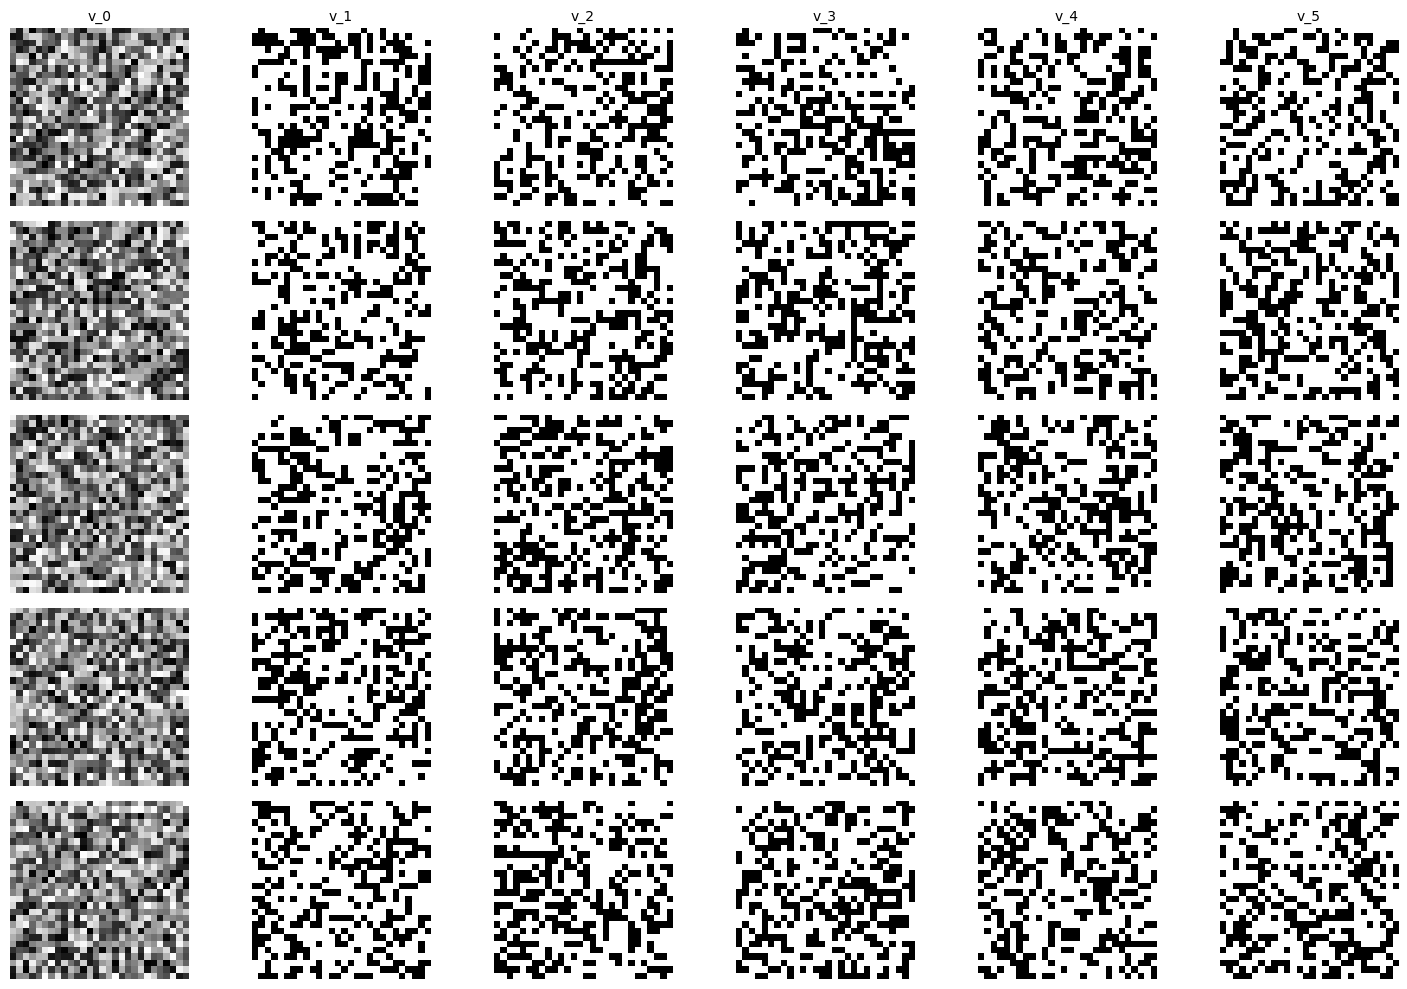

In [34]:
def visualize_mcmc_process(rbm, n_samples=5, k=5):
    """
    Visualize the MCMC process in RBM (v_0, v_1, ..., v_k).
    """
    samples = np.random.rand(n_samples, rbm.n_visible)  # Random initialization
    process = [samples]  # Store intermediate states

    # Perform Gibbs sampling for k steps and store each step
    for _ in range(k):
        h_prob = rbm.sigmoid(np.dot(samples, rbm.W) + rbm.h_bias)
        h_sample = rbm.sample(h_prob)
        v_prob = rbm.sigmoid(np.dot(h_sample, rbm.W.T) + rbm.v_bias)
        samples = rbm.sample(v_prob)
        process.append(samples)

    # Visualize the process for each sample
    fig, axes = plt.subplots(n_samples, k + 1, figsize=(15, n_samples * 2))
    for i in range(n_samples):
        for j in range(k + 1):
            ax = axes[i, j] if n_samples > 1 else axes[j]
            ax.imshow(process[j][i].reshape(28, 28), cmap='binary')
            ax.axis('off')
            if i == 0:
                ax.set_title(f"v_{j}", fontsize=10)
    plt.tight_layout()
    plt.show()

# Visualize the MCMC process for k=5 with the trained RBM (k=1)
visualize_mcmc_process(rbms[1], n_samples=5, k=5)

Q_4

In [30]:
# class ConditionalRBM(RBM):
#     def __init__(self, n_visible, n_hidden, n_classes):
#         super().__init__(n_visible + n_classes, n_hidden)
#         self.n_classes = n_classes

#     def train(self, data, labels, epochs=10, k=1, lr=0.01, batch_size=64):
#         data_with_labels = np.hstack([data, labels])  # Append class labels
#         super().train(data_with_labels, epochs, k, lr, batch_size)

#     def generate_samples(self, target_label, n_samples=10, k=1):
#         # Initialize samples and set target label
#         samples = np.random.rand(n_samples, self.n_visible)
#         labels = np.zeros((n_samples, self.n_classes))
#         labels[np.arange(n_samples), target_label] = 1
#         samples_with_labels = np.hstack([samples, labels])

#         # Perform Gibbs sampling
#         generated = self.gibbs_sampling(samples_with_labels, k)
#         return generated[:, :-self.n_classes]  # Return only the visible units

# # Prepare one-hot encoded labels
# n_classes = 10
# y_train_one_hot = np.eye(n_classes)[Y_train]  # Convert labels to one-hot

# # Train a conditional RBM
# conditional_rbm = ConditionalRBM(n_visible, n_hidden, n_classes)
# print("Training Conditional RBM...")
# conditional_rbm.train(x_train_binary, y_train_one_hot, epochs=5, k=1, lr=0.01, batch_size=64)

# # Generate samples for specific digits
# target_digits = [0, 1]  # Digits to generate
# for digit in target_digits:
#     print(f"Generated samples for digit {digit}:")
#     generated_samples = conditional_rbm.generate_samples(target_label=digit, n_samples=5, k=5)
#     generated_samples = generated_samples.reshape((-1, 28, 28))
#     fig, axes = plt.subplots(1, 5, figsize=(15, 3))
#     for i, ax in enumerate(axes):
#         ax.imshow(generated_samples[i], cmap='binary')
#         ax.axis('off')
#     plt.show()

def generate_specific_digit(rbm, digit, data, labels, num_samples=10, num_gibbs_steps=10):
    # Filter data for the specified digit
    digit_data = data[labels == str(digit)]

    # Calculate the mean representation for the given digit
    mean_representation = np.mean(digit_data, axis=0)

    generated_samples = []
    for _ in range(num_samples):
        visible_layer = mean_representation.copy()

        for _ in range(num_gibbs_steps):
            # Sample the hidden layer
            h_prob = rbm.sigmoid(np.dot(visible_layer, rbm.W) + rbm.h_bias)
            h_sample = rbm.sample(h_prob)

            # Sample the visible layer
            v_prob = rbm.sigmoid(np.dot(h_sample, rbm.W.T) + rbm.v_bias)
            visible_layer = rbm.sample(v_prob)

            # Incorporate the mean representation for controlled generation
            visible_layer[mean_representation > 0.5] = mean_representation[mean_representation > 0.5]

        # Reshape and store the generated sample
        generated_samples.append(visible_layer.reshape(28, 28))

    return generated_samples

# Example usage
digit_to_generate = 0
controlled_samples = generate_specific_digit(rbm, digit_to_generate, x_train_binary, Y_train, num_samples=10)

def display_controlled_samples(samples):
    plt.figure(figsize=(10, 2))
    for i, sample in enumerate(samples):
        plt.subplot(1, len(samples), i + 1)
        plt.imshow(sample, cmap='gray')
        plt.axis('off')
    plt.suptitle(f"Generated Samples for Digit {digit_to_generate}")
    plt.show()

display_controlled_samples(controlled_samples)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


AttributeError: 'RBM' object has no attribute 'sample_hidden'